# GEN-level distribution for CP in tau decays analysis (purely pythonic)

This is just to illustrate what can be done. JupyerLab works like a notebook but you have access to
all files on /vols/build/cms and /vols/cms which is obviously very helpful for us. The current directory is the 
one you initiated the session in: you can check this with:

In [24]:
!pwd

/vols/build/cms/akd116/Notebooks


Anything saved will therefore be there.

This means you can cd anywhere you like as well. Just keep in mind that directories with many files might slow down jupyterlab.

You can also activate vim bindings under `Settings/Text Editor Key Map` if that is what you are used to.

Now let's try to run an example:

In [20]:
# load in the required packages 
# this example will be purely pythonic, no ROOT or CMSSW dependency
import uproot # to load in ROOT files
import matplotlib.pyplot as plt # for plotting
import numpy as np # always use numpy
import pandas as pd # for dataframes, use together with uproot to essentially replace ROOT.TTree
import itertools

# file to be opened
# this one is stored on /vols/cms/
test_file = (
    "/vols/cms/akd116/Offline/output/SM/2020/jl_example/"
    "VBFHToTauTauUncorrelatedDecay_Filtered_2018_tt_0.root"
)

# open TTree called 'gen_ntuple'
f = uproot.open(test_file)["gen_ntuple"] 

# you can look at the keys with f.keys()
# and select which branches you want:
branches = [
    "cp_channel",
    "aco_angle_1",
    "wt_cp_sm",
    "wt_cp_ps",
    "wt_cp_mm",
]
# then load these events into a pandas DataFrame
df = f.pandas.df(branches, namedecode="utf-8")

In [13]:
# set up options here (these are physics motivated)
cp_channel = 3 # for physics channel involving tau tau -> rho rho
plot_var = "aco_angle_1"
# to obtain CP-sensitive distributions we reweight by the corresponding
# weight
weights = ["wt_cp_sm", "wt_cp_ps", "wt_cp_mm"]
legend_items = [
    r"$\mathrm{SM}\ (\phi_{\tau}=0)$",
    r"$\mathrm{PS}\ (\phi_{\tau}=\pi/2)$",
    r"$\mathrm{MM}\ (\phi_{\tau}=\pi/4)$",
]

In [14]:
# to have CMS labelled plots 
def cms_label(ax, label, lumi=35.9, energy=13, extra_label=""):
    ax.text(
        0, 1, r'$\mathbf{CMS}\ \mathit{'+label+'}$',
        ha='left', va='bottom', transform=ax.transAxes,
    )
    ax.text(
        1, 1, r'${:.1f}\ \mathrm{{fb}}^{{-1}}$ ({:.0f} TeV)'.format(lumi, energy),
        ha='right', va='bottom', transform=ax.transAxes,
    )


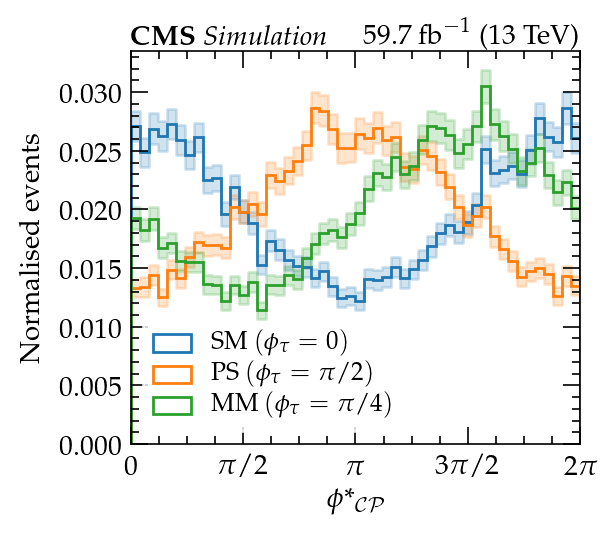

In [23]:
plt.style.use('cms') # use CMS-style, can comment if want to use default matplotlib style
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = itertools.cycle(prop_cycle.by_key()['color'])

fig, ax = plt.subplots(figsize=(2.9, 2.6), dpi=200,)

cms_label(ax, "Simulation", lumi=59.7)

# binning
bin_edges = np.linspace(0, 2.*np.pi, endpoint=True, num=51) 
bin_low_edge = bin_edges[:-1]

# loop over different CP-scenarios
for weight in weights:
    # create histogram content for each bin
    sum_w, _ = np.histogram(
        df.loc[df.eval(f"cp_channel=={cp_channel}"), plot_var],
        bins=bin_edges,
        weights=df.loc[df.eval(f"cp_channel=={cp_channel}"), weight],
    )
    # normalise by integral
    sum_w_total = sum_w.sum()
    sum_w /= sum_w_total
    # obtain statistical uncertainty (assumes Gaussian errors)
    sum_ww, _ = np.histogram(
        df.loc[df.eval(f"cp_channel=={cp_channel}"), plot_var],
        bins=bin_edges,
        weights=(df.loc[df.eval(f"cp_channel=={cp_channel}"), weight])**2,
    )
    # normalise uncertainty as well (by square of integral)
    sum_ww /= (sum_w_total)**2
    # this makes sure colours are the same for histogram and error band
    color=next(colors),
    # draw histogram onto axis
    ax.hist(
        bin_low_edge,
        bins=bin_edges,
        histtype='step',
        weights=sum_w,
        color=color,
    )
    # get up and down error
    up = sum_w + np.sqrt(sum_ww)
    down = sum_w - np.sqrt(sum_ww)
    # draw error band with fill between function
    ax.fill_between(
        bin_edges,
        list(up)+[up[-1]],
        list(down)+[down[-1]],
        step='post',
        alpha=0.2,
        color=color,
    )
    
# add legend with some options
ax.legend(
    legend_items,
    loc=3, 
    labelspacing=0.2, 
    fontsize=9.,
    framealpha=0.8,
)

# finally label and choose axis limits etc.
ax.set_xlim(0, 2.*np.pi)
ax.set_ylabel("Normalised events")
ax.set_xlabel(r'$\phi\mbox{*}_{\mathcal{CP}}$')
ax.set_xticks([0, np.pi/2, np.pi, 1.5*np.pi, 2.*np.pi])
ax.set_xticklabels([0, r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])

# save file
fig.savefig("example.pdf", bbox_inches='tight')

The powerful thing of this set-up (in my opinion) is the transparency of pandas dataframes and the ability to print anything.
Dataframes are essentially TTrees but you can manipulate numbers as you wish, make selections with pandas 
and see exactly what enters you bins. For example I can print the dataframe like this:

In [18]:
df

,cp_channel,aco_angle_1,aco_angle_2,aco_angle_3,aco_angle_4,wt_cp_sm,wt_cp_ps,wt_cp_mm
entry,,,,,,,,
0,-1,9999.0000,9999.0,9999.0,9999.0,1.946667,0.061697,1.223270
1,-1,9999.0000,9999.0,9999.0,9999.0,1.304017,0.199793,0.379287
2,-1,9999.0000,9999.0,9999.0,9999.0,1.931258,0.542882,0.926350
3,2,1.7545,9999.0,9999.0,9999.0,1.838380,0.695684,1.485048
4,-1,9999.0000,9999.0,9999.0,9999.0,1.247756,1.950832,1.475083
...,...,...,...,...,...,...,...,...
519533,-1,9999.0000,9999.0,9999.0,9999.0,1.574162,1.523448,1.933410
519534,-1,9999.0000,9999.0,9999.0,9999.0,0.284749,1.707995,1.692921
519535,-1,9999.0000,9999.0,9999.0,9999.0,1.114839,0.655647,0.132585


Make selections like this:

In [21]:
df.query("cp_channel==3")

,cp_channel,aco_angle_1,wt_cp_sm,wt_cp_ps,wt_cp_mm
entry,,,,,
39,3,5.685923,1.471807,0.555582,1.721755
47,3,4.814805,1.299909,0.755633,1.879174
75,3,0.540957,1.461441,0.329555,0.265421
88,3,4.950186,1.126170,0.636602,0.038299
112,3,3.124205,0.235559,1.710146,0.535728
...,...,...,...,...,...
519476,3,5.130294,1.571478,1.089663,1.912148
519494,3,1.950475,0.691117,1.544022,0.656756
519498,3,5.442049,1.726653,0.726227,1.336931


To me this makes debugging and working in general much more productive and visual.
Clearly this is great for working with machine learning tools such as xgboost, keras or pytorch.